# Classifying Traffic Signs With a Convolutional Neural Network

The following code builds off the LeNet lab from the Udacity self driving car nano degree, term one. I have written my own architiecture for a new convolutional neural net following inpiriation from the GoogLeNet paper and source [2], defined below. 
I still have a network with a humble number of layers, though I've added something akin to an inception module as described in source [1], and an extra fully connected layer in the final stages of the network. Additionaly, I added dropout to the weights of the fully connected layers, excluding the logit layer, and l2 regularization penalties on all fully connected layer weights. I tuned all the hyper parameters mannually to get a decent fit (in this case accuracy). 
___

Additinally, I added the preprocessing steps of appending an upside-down rotation to of all labeled data, doubling the number of training examples and divided all values of input data by 255, forcing the range to [0, 1] for input features.
___

Before final testing, I tried the network on a few pictures of signs outside of the training set I found online, but were still one of the 43 classes represented in the dataset. 
___

Just for fun, and to illustrate the limitations of supervised classification and help understand the model better, I ran the trained model on some "out-of-sample" pictures, including paint illustrations and a downsampled picture of my face. The point being, even though a classifier may seem incredible when you look at the performance metrics, you still need to be careful to keep it in its "play-pen" during use or the model could behave in a surprising or even dangerous way.
___


Here's a visual of my archetecture, style inspiried by:
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf

![My Architecture](sign_classifier_2.png)

## Data Set Summary

###### Data description from class material:

The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 2D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES


## Import Libraries and Load Data

First thing, I imported all the libraries and functions, and used the code from the class material to import the traffic sign data. 

In [2]:
#============================================================================
# Load pickled data
import pickle
import numpy as np
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
from random import randint
import copy

# Visualizations will be shown in the notebook.
%matplotlib inline

# import tensorflow
import tensorflow as tf

# sklearn data prep functions 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# For visualizing loaded pictures 
import matplotlib.image as mpimg
import os

# import read csvpandas
from pandas import read_csv
#===================================================================

In [3]:
#============================================================================
# load data and define train, valid, and test sets 
training_file = "/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/data/train.p"
validation_file= "/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/data/valid.p"
testing_file = "/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
#============================================================================

## Data Exploration
I breifly explored the imported data by plotting a histogram of class insances. There is somemclass imbalance, howeer, I will continue without correcting this now. The speed limit signs occur rather frequently compared with other classes, and pedestrians, end of passing, bumpy road, and road narrows on right are examples of the least represented classes. I'm guessing this will translate to higher confidences in speed limit predictions than in some of the less represetned classes. 

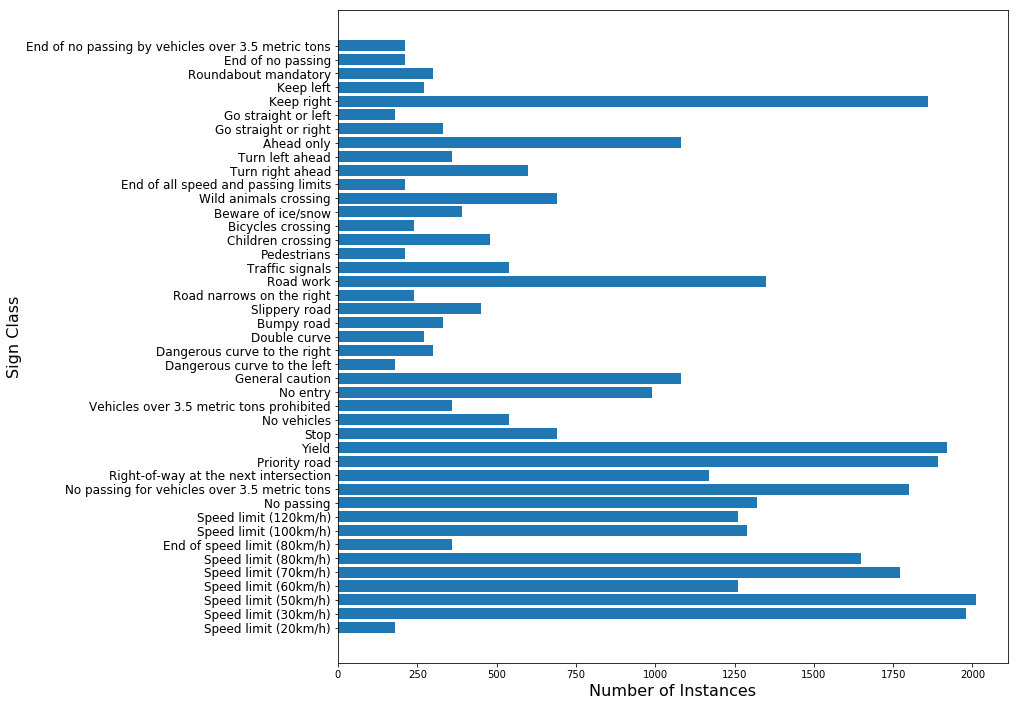

In [5]:
# observe class distribution of data. 
# modifed from the class material
# histogram of label frequency

# read in sign class labels
class_names = read_csv('/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/signnames.csv')

labs = class_names['SignName']

n_classes = 43
hist, bins = np.histogram(y_train, bins=n_classes)
center = np.arange(0,43,1)

# build plot
plt.barh(center, hist, align='center')
plt.ylabel('Sign Class', fontsize=16)
plt.xlabel('Number of Instances', fontsize=16)
plt.yticks(range(len(labs)), labs, size='large', rotation = 0)
plt.rcParams['figure.figsize'] = (12, 12) 

# print the plot 
plt.show()


## Data preprocessing
I preprocessed the data with a few simple steps:
* Combining training and validation sets
* Copying the combined set and rotating all images 180 degrees to an upside-down orientation 
* Appending the original and rotated
* Dividing the resulting dataset by 255 to force input range to [0, 1]
* Separating the data into 80% of the labeled data into the training set, and 20% into the validation set 

I repeated the transformitive preprocessing operatinons on the test set

Additinally, I selected 9 examples from the original training set, and 9 from the rotated set before dividing by 255 and plotted them.

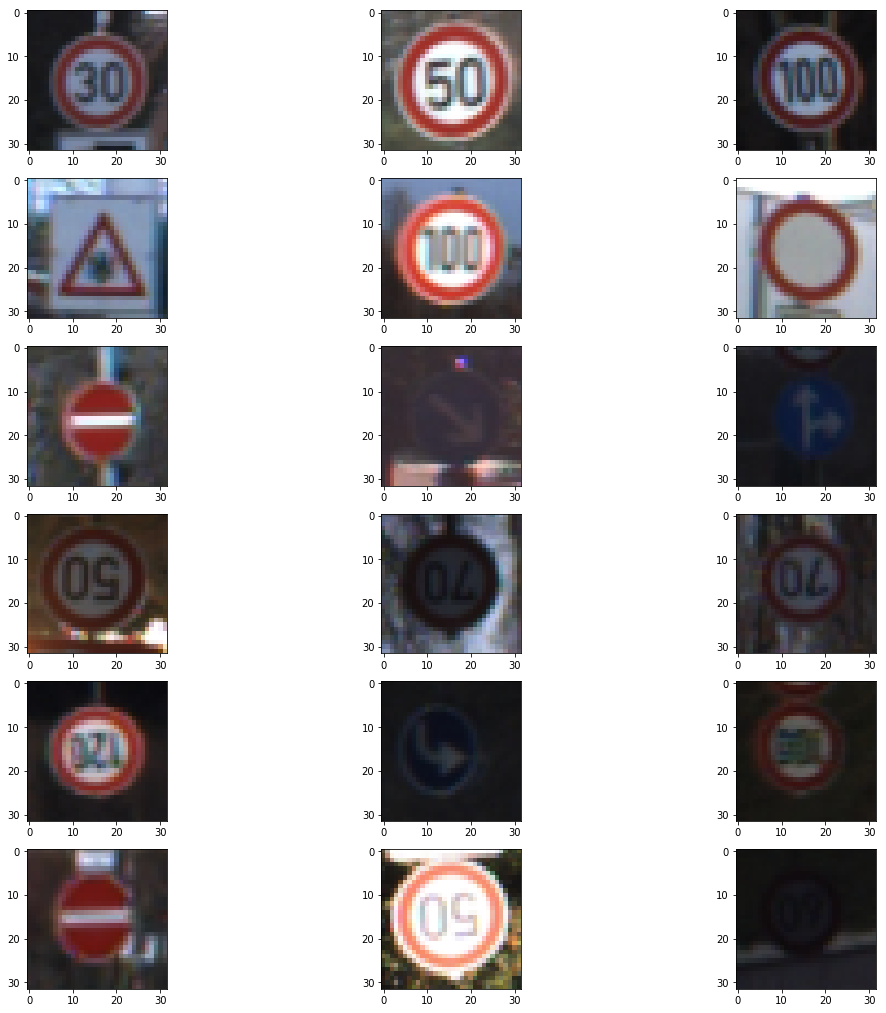

In [6]:
#============================================================================
# Data exploration, visualization, and prep
# reload shuffle, masked by later imports 
from sklearn.utils import shuffle
# select a few example images from a few classes from train\
def rand_subset(X_train, index = 9):
    #selected_classes = []
    #for i in range(0, 5):
        #selected_classes.append(randint(train["labels"].min(), train["labels"].max()))

    # grab a subset of classes
    #train_subset = {"features": train["features"] for label in selected_classes}

    # get a few random selections 
    selected_index = []
    for i in range(0, index):
        selected_index.append(randint(0, X_train.shape[0]-1))
    
    # final subset 
    train_subset = X_train[selected_index,:,:,:]
    
    return train_subset
#============================================================================

#============================================================================
# combine for one processing of training
X_both = np.vstack([X_validation, X_train])
y_both = np.hstack([y_validation, y_train])
#============================================================================


#============================================================================
# define the rotation function. rotates to the left 90 degrees*times
def rotate(x, times = 0):
    for i in range(0, np.shape(x)[0]):
        x[i,:,:,0] = np.rot90(x[i,:,:,0], times)
        x[i,:,:,1] = np.rot90(x[i,:,:,1], times)
        x[i,:,:,2] = np.rot90(x[i,:,:,2], times)
    return x
#============================================================================

#============================================================================
# put the data prep steps in a function for easy repeat on test data
from copy import deepcopy
def data_prep(X, y, vis_num = 3):
    # get an upside down version 
    cpy = deepcopy(X)
    X_c = rotate(cpy, 2)
    X_big = np.vstack([X_c, X])
    X_01 = X_big / 255
    
    if y is not None:
        # double up the labels and 
        y_01 = np.hstack([y, y])
        # shuffle
        X_01, y_01 = shuffle(X_01, y_01)
    else:
        X_01  = shuffle(X_01)
        y_01 = None

    # the final has very small values, so wont look like anything look at the rotation
    x_sub = rand_subset(X_c)

    # the originals
    train_subset = rand_subset(X, index = vis_num)
    
    tplot = []
    tplot = np.vstack([train_subset, x_sub])
    
    return X_01, y_01, tplot
#============================================================================
  
#============================================================================
# run prep function on training and validation combo data
X_01, y_01, tplot = data_prep(X_both, y_both, vis_num = 9)

# split into train and validation again 
X_train, X_validation, y_train, y_validation= train_test_split(X_01, y_01, test_size= 0.2)

# just do the division on the test data
#X_test, y_test, plot_test = data_prep(X_test, y_test)
X_test_process = X_test / 255
#============================================================================

#============================================================================
# plot seected examples from original and rotated sets
plt.figure(figsize=(18, 18))
for i, image in  enumerate(tplot):
    plt.subplot(6,3,1+i)
    plt.imshow(image)
#============================================================================

## Model Archetecture
The model is a combination of the class lab on LeNet, my code, and inspiration from these sources:

source [1] https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf 


source [2] https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/

---

The archetecture is as follows: 

* Input   : 32x32x3


* Layer  1: 

    * 3x3x6 filter Convolution

    * 2x2x6 filter Max pool
    

* Layer  2: 5x5x12 filter Convolution


* Layer  3: Inception module concatonating:
    * 1x1x12 filter convolution
    
    * 1x1x12 filter convolution -> 5x5x12 filter convolution
    
    * 3x3x12 filter Max pool -> 1x1x12 filter convolution
    
    * 1x1x12 filter convlution -> 3x3x12 filter convolution
    
    
* Layer  4:
    * 7x7x60 filter convolution

    * 2x2x60 filter Max pool
     

* Layer  5: Fully connected with dropout 240x500

* Layer  6: Fully connected with dropout 500x250

* Layer  7: Fully connected with dropout 250x125

* Layer  8: Fully connected 125x43


* Output  : Softmax layer put in loss function

---

Loss function includes l2 regularization on all weights in fully connected layers.

In [7]:
#=============================================================================
# New net as described above. In addition to logits, returns the fully connected 
#  layer's weights for l2 penalty in loss function.  
def new_net(x):    
    #=============================================================================
    # hyper params
    mu = 0
    sigma = 0.1
    #keep_prob = 1
    
    #=============================================================================

    #=============================================================================
    # conv Layer 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # pooling 1
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================

    #=============================================================================
    # conv Layer 2
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 12), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(12))
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    #=============================================================================
    
    #=============================================================================
    # layer 3: try inception-like layer 
    incept1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept1_b = tf.Variable(tf.zeros(12))
    incept1   = tf.nn.conv2d(conv2, incept1_W, strides=[1, 1, 1, 1], padding='SAME') + incept1_b
    incept1 = tf.nn.relu(incept1)
    
    incept2_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept2_b = tf.Variable(tf.zeros(12))
    incept2   = tf.nn.conv2d(conv2, incept2_W, strides=[1, 1, 1, 1], padding='SAME') + incept2_b
    incept2 = tf.nn.relu(incept2)
    
    incept3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 12), mean = mu, stddev = sigma))
    incept3_b = tf.Variable(tf.zeros(12))
    incept3   = tf.nn.conv2d(incept2, incept3_W, strides=[1, 1, 1, 1], padding='SAME') + incept3_b
    incept3 = tf.nn.relu(incept3)
    
    incept4 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')

    incept5_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept5_b = tf.Variable(tf.zeros(12))
    incept5   = tf.nn.conv2d(incept4, incept5_W, strides=[1, 1, 1, 1], padding='SAME') + incept5_b
    incept5 = tf.nn.relu(incept5)
    
    incept6_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept6_b = tf.Variable(tf.zeros(12))
    incept6   = tf.nn.conv2d(conv2, incept6_W, strides=[1, 1, 1, 1], padding='SAME') + incept6_b
    incept6 = tf.nn.relu(incept6)
    
    incept7_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 12, 12), mean = mu, stddev = sigma))
    incept7_b = tf.Variable(tf.zeros(12))
    incept7   = tf.nn.conv2d(incept6, incept7_W, strides=[1, 1, 1, 1], padding='SAME') + incept7_b
    incept7 = tf.nn.relu(incept7)
    
    concat_layer = tf.concat(3,[incept1, incept3, incept5, incept7])
    concat_layer = tf.nn.relu(concat_layer)
    #=============================================================================
    
    #=============================================================================
    # layer 4: conv 2d
    conv3_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 48, 60), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(60))
    conv3   = tf.nn.conv2d(concat_layer, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    # pooling 2
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================
      
    #=============================================================================
    # flatten out for fc layer 
    fc0   = flatten(conv3_pool)
    #=============================================================================
    
    #=============================================================================
    # fully connected layers with dropout
    # layer 5: fully connected with dropout, relu
    fc1_W = tf.Variable(tf.truncated_normal(shape=(240, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 6: Fully Connected with dropout, relu
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 250), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(250))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 7: Fully Connected with dropout, relu
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(250, 125), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(125))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    fc3    = tf.nn.relu(fc3)
    fc3    = tf.nn.dropout(fc3, keep_prob)

    # Layer 8: Fully Connected relu
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(125, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    #=============================================================================

    # return logits before softmax and fc weights
    return logits, fc1_W, fc2_W, fc3_W, fc4_W

## Define remainder of model and training gradient
* Define place holders
* Define learning rate input to Adam optimizer 
* Define l2 loss constant (ended up being 0.01, rather high in my oppinion
* Evaluation function, set to return accuracy, metric chosen from the lab material
* Set epochs
* Set batch size

I tried a few different batch sizes, including a large one, though the 128 seemed to be the fastest. Through manual hyper parameter tuning, I found about 40 epochs and a l2 loss constant of 0.01 to get a pretty good score. Additinoally, I tuned the keep_prob rate definined in the new_net function to 0.5 through trial and error. Additionally adadelta was used as an alternative optimization scheme, though adam proved to be better. 



In [8]:
#==========================================================================
# Define placeholders 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32, (None))
#==========================================================================

#==========================================================================
# rate into Adam optimizer
rate = 0.001 
# hyper parameter: l2 loss constant, 1*10^-4 (my experience, kind of big.)
loss_const = 0.01 #0.0000411
#==========================================================================

#==========================================================================
# get outputs, calcualte loss and define training gradient
logits, fc1_W, fc2_W, fc3_W, fc4_W = new_net(x)
cross_entropy_l2 = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# define this for predictins later
preds = tf.placeholder(tf.float32, (None, 32))
preds = tf.nn.softmax(logits)
preds = tf.Print(preds, [preds])

# calcualte the l2 loss penalty
loss_penalty = loss_const*tf.nn.l2_loss(fc1_W) + loss_const*tf.nn.l2_loss(fc2_W) + loss_const*tf.nn.l2_loss(fc3_W) + loss_const*tf.nn.l2_loss(fc4_W)

# feed it into the mean 
loss_operation = tf.reduce_mean(cross_entropy_l2 + loss_penalty)

# keep adam as optimizer for now
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

# run minimize 
training_operation = optimizer.minimize(loss_operation)
#==========================================================================

In [9]:
#============================================================================
# define the performance operations 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
#============================================================================

#============================================================================
# evaluate the model from the default session and input X and y. 
# use this equation for testing and on non-training data
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
#============================================================================

## Train the Model
Run the training data through the training pipeline to train the model. This function from the class material. 

Brief summary:

* Before each epoch, shuffles the training set.

* After each epoch, measures the loss and accuracy of the validation set.

* prints out training and validation metrics at each epoch

* Saves the model after training
___
The result, ~98% accuracy on train, ~97% accuracy on validation suggest that the model is not overfit, though, its worth exploring further. I used the training code from the example, but modified it to print out training and validation metrics to check for overfitting during training. 

In [9]:
#============================================================================
# Train the model on X_train and y_train from the data_prep function
EPOCHS = 50
# small batch size seems to run faster
BATCH_SIZE = 128
#============================================================================

#============================================================================
# Tensor flow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    print("epoch,train_acc,valid_acc")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
           
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        # edited for easy copy-paste to visualize training history 
        print("{}".format(i+1) + ",{:.3f}".format(training_accuracy) + ",{:.3f}".format(validation_accuracy)) 

    saver = tf.train.Saver()
    saver.save(sess, "./train_50", global_step = EPOCHS)
    print()
    print("Model saved")  
#============================================================================

Training...

epoch,train_acc,valid_acc
1,0.465,0.461
2,0.627,0.622
3,0.759,0.749
4,0.823,0.812
5,0.856,0.852
6,0.890,0.884
7,0.892,0.885
8,0.910,0.898
9,0.912,0.907
10,0.928,0.915
11,0.925,0.916
12,0.945,0.935
13,0.946,0.938
14,0.953,0.944
15,0.950,0.938
16,0.950,0.940
17,0.957,0.944
18,0.962,0.953
19,0.959,0.950
20,0.951,0.944
21,0.959,0.950
22,0.964,0.951
23,0.971,0.961
24,0.967,0.957
25,0.957,0.945
26,0.970,0.962
27,0.969,0.959
28,0.966,0.955
29,0.971,0.958
30,0.968,0.958
31,0.974,0.960
32,0.974,0.965
33,0.971,0.960
34,0.974,0.963
35,0.979,0.965
36,0.980,0.968
37,0.977,0.966
38,0.979,0.968
39,0.982,0.973
40,0.975,0.963
41,0.981,0.971
42,0.979,0.969
43,0.982,0.972
44,0.981,0.972
45,0.980,0.967
46,0.978,0.967
47,0.976,0.966
48,0.979,0.968
49,0.970,0.956
50,0.985,0.973

Model saved


# New Images Outside of Dataset

For further testing, I classified some new images that did not come with the data set. These images were found through an online image search, and preprocessed to 32x32 RGB pixel images with similar contraints as seen in the dataset. Each new image is a picutre of one of the sign classes included in the training data. 

The purpose of this exersize is to seen how the classifier does with actual new pictures, before trying the hold-out test data. In addition, it may help to gain insight into how the model works and what its strengths and weaknesses are. 

The left turn ahead and stop sign are both front facing. I chose a left trun because it has many fewer examples in the training data and I was intereted to see how a new sign of this class would be classified. The pedestrain sign is an at an more extreme angle compared to much of the training data, snow covers a portion of the yeild sign, and for an experiment, the 30 kph speed limit sign has been vandalized to say "130." Such a instance could be encountered in actual implementation, and humans have no problem reading the sign as "30" but, I wanted to see if the classifier could. 

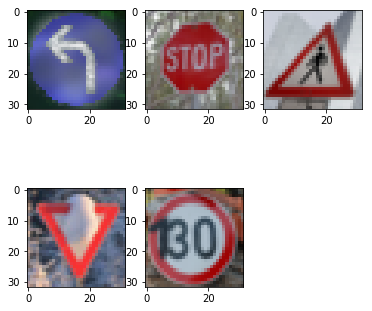

In [10]:
%matplotlib inline

#===================================================================
# change working directory
os.chdir("/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/pics/test_signs/")
# file names of the exra pics
images = os.listdir()

#===================================================================
#read them in 
extra_images = []
for img in images:
    read_in = (mpimg.imread(img))
    #slice off the alpha channel 
    slice_in = read_in[:,:,0:3]
    extra_images.append(slice_in)
    
look = np.stack(extra_images, axis = 0)
#===================================================================

#===================================================================
# make the data like X_train 
#X_wild, y_empty, plot_pics = data_prep(X = look_slice[0:3], y = None, vis_num = 2)
X_wild = look
#===================================================================

#============================================================================
# plot seected examples from original and rotated sets
plt.figure(figsize=(6, 6))
for i, image in  enumerate(look):
    plt.subplot(2,3,1+i)
    plt.imshow(image)

## Classifying New Images

Next, I ran the new images through the classifier, outputting the softmax probabilities for all classes, and the most probable class. In all but 1 case, the most probable class was the correct one. The grafitied 30 kph speed limit sign was incorrectly classifeid as a general caution sign. After exploring outputs a bit, I found that the general caution class is often predicted when I feed the network something weird. However, the correct label, the 30 kph sign, was the second most probable class.

Summary of Results: 
Left turn ahead: 

Given these results, I chose to continue to model testing. 


In [55]:
# change back to model file path
os.chdir("/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/")


# Print out all soft max class predictions of new signs. 
with tf.Session() as sess:
    # load the saved model from training 
    sess = tf.Session()
    #saver = tf.train.import_meta_graph("train_45.meta")
    saver.restore(sess, tf.train.latest_checkpoint("."))
    get = sess.run(preds, feed_dict={x: X_wild, keep_prob: 1})
    get_class = np.flip(np.argsort(get, axis =1 ), axis = 1)
    get_prob = np.flip(np.sort(get, axis =1 ), axis = 1)
    choose = tf.argmax(get, 1)  
    print('All Classes In Order of Decending Probability:', '\n', get_class, '\n', 'Ordered Probabilities', '\n', get_prob, '\n', 'Most Probable:', '\n', choose.eval(session=sess))
    

All Classes In Order of Decending Probability: 
 [[34 10 21 37 12 19 11 17 40 14  4 18  9 42 30 23 41 38  1  2  7 15 31 13
  36  8 35 33  6 16 26 24 22  5  0 25 20 27 32  3 39 29 28]
 [14 36 22 16 20  3  6 17  0 32  5  1 25 19 37 12 34 10 41 33 30 28 42  9
  11 23 13 21 15 38 39 24 35 40  2  4 26  7 18 31 29 27  8]
 [27 26 39 30 25 31 24 28 11 21 18 33 20 40 37  6 29 42  1 22 13 19 35 23
  32  4  0 38 41 17 14 16 10  5 12 15  7 36  2  8 34  3  9]
 [13 22 29 26 31 24 20 38 19 25 23 28 39 27 30 40  0 15 21  3  2  1 37  4
   9 36 35  8 34 18 14 16 32 42  5 41 33 17  6 10  7 12 11]
 [18  1  2  4 12 27 26 11 21  6 15 31  0  5 35 32 33 13 25 37 10 24 42 17
  34 14 22  8  3 36 28 30 40  7 41 19 20  9 39 29 16 38 23]] 
 Ordered Probabilities 
 [[  4.03088480e-01   2.05377102e-01   7.62632191e-02   5.61101884e-02
    4.92416397e-02   4.59231250e-02   3.70742902e-02   3.10007986e-02
    2.08798200e-02   1.37996459e-02   1.18618011e-02   7.43942708e-03
    7.39999954e-03   7.35042198e-03   5.0005

## Evaluate the Model
Post-training, and new sign check, I tested the model on a decent amount of hold-out data for a "one-and-done" test evaluation. The result is a test accuracy of about 92%, 5% lower than the final validation number. Thats not awesome, but it will do for this project. 

In [64]:
# redefine batch sze (if loading from saved)
BATCH_SIZE = 128

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint("."))
    test_accuracy = evaluate(X_test_process, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.940


### Test Results

The holdout test data was predicted with an accuracy of about 94%. Not breaking any records, but it will do for this project.

___
## Just for Fun
In addition to traffic signs, I ran a few extra examples to see what the network would think picutures of other things are. 



* A roadside group of balloons, (graduation party?) 

![](./pics/big_balloons.png)


* A stick person that might look like a traffic sign:

<img src="./pics/blue_big.png"/>


* And, why not, me: 

<img src="./pics/me_big.jpg" style="width: 200px;"/>

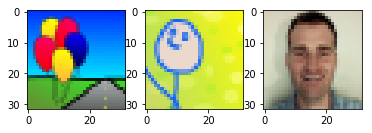

In [11]:
%matplotlib inline

#===================================================================
import matplotlib.image as mpimg
import os
#===================================================================

#===================================================================
# change working directory
os.chdir("/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/pics/extra_signs/")
# file names of the exra pics
images = os.listdir()

#===================================================================
#read them in 
extra_images = []
for img in images:
    read_in = (mpimg.imread(img))
    #slice off the alpha channel 
    slice_in = read_in[:,:,0:3]
    extra_images.append(slice_in)
#===================================================================
  
#===================================================================
# make the data like X_train
look = np.stack(extra_images, axis = 0)

X_wild = look
#===================================================================

#============================================================================
# plot seected examples from original and rotated sets
plt.figure(figsize=(6, 6))
for i, image in  enumerate(look):
    plt.subplot(2,3,1+i)
    plt.imshow(image)
#============================================================================  

In [12]:
#============================================================================
# change back to model file path
os.chdir("/home/andrewrs/Desktop/udacity/Traffic-Sign-Classifier/")

# Print out all soft max class predictions of new signs. 
with tf.Session() as sess:
    # load the saved model from training 
    sess = tf.Session()
    #saver = tf.train.import_meta_graph("train_45.meta")
    saver.restore(sess, tf.train.latest_checkpoint("."))
    get = sess.run(preds, feed_dict={x: X_wild, keep_prob: 1})
    get_class = np.flip(np.argsort(get, axis =1 ), axis = 1)
    get_prob = np.flip(np.sort(get, axis =1 ), axis = 1)
    choose = tf.argmax(get, 1)  
    print('All Classes In Order of Decending Probability:', '\n', get_class, '\n', 'Ordered Probabilities', '\n', get_prob, '\n', 'Most Probable:', '\n', choose.eval(session=sess))



All Classes In Order of Decending Probability: 
 [[ 4  1 15  0 12 36 22 34 38 24  2 21  8 19 13 40 18 14 37 25 42  7 26 35
  41 27 17  3 32 33  6 39  5 31  9 28 30 10 29 20 11 16 23]
 [ 1 36 14 32 22  6  3  0 25 20  5 12 34 28 33 13 26 41 19 35 37  4 18 16
  17 24 38 15 42 30  2 21 11 27 40  8 29  9 10 39 31  7 23]
 [ 3 28  0 20 32 29  8 13 36 22  1  5 41 26  9 30 38 35 14 19 24 15 25  6
  34  2 33 39 16 31 23  4 27 18 42  7 40 21 37 17 11 12 10]] 
 Ordered Probabilities 
 [[  5.53048432e-01   3.46167445e-01   2.82301567e-02   2.29765680e-02
    2.02415679e-02   1.22845853e-02   7.26316310e-03   6.26230426e-03
    8.56639352e-04   4.98330570e-04   4.62719618e-04   3.64316365e-04
    3.33304459e-04   3.10996722e-04   1.71847991e-04   1.47300903e-04
    1.26039886e-04   7.98031760e-05   7.02040998e-05   2.08915317e-05
    1.88031572e-05   1.38891683e-05   1.28139854e-05   7.27687939e-06
    5.55521956e-06   4.48378842e-06   3.54575081e-06   2.79231972e-06
    2.51824008e-06   1.92544871e

### Results of Extra Images

* The network gave a very high (0.91) score labeling the road side balloons as "dangerous curve to the right"


<img src="pics/big_balloons.png" style="width: 100px;"/>

<img src="pics/compare_signs/right_curve.png" style="width: 100px;"/> 

* Insta stickman got labeled a bumpy road sign with 0.55 confidence.


<img src="pics/blue_big.png" style="width: 100px;"/>  

<img src="./pics/compare_signs/bumpy.jpg" style="width: 100px;"/> 

* And it turns out, I'm a road work sign with 0.76 confidence. I guess its better than being a bad egg. 


<img src="./pics/me_big.jpg" style="width: 100px;"/> 

<img src="./pics/compare_signs/road_work.jpg" style="width: 100px;"/> 


Specualtive interpretation might point to the amount of red and the fact that there are come black lines curving to the right in the first case. The stick man is kind of a mystery on first inspection, although you could imagine his mouth and googley-eyes as looking something like a decompose version of the double-bump symbol. As for my face, there are some complex structures, and the model chose one of the more complex signs. Additionally, my eyes make a small circular structure similar to the head of the working person in the sign, and a minority of signs exibit that structure in the training data (pedestrians, the period in the caution sign, etc, which could influence the final label toward one of these signs.

Although primarily a just-for-fun exercise, feeding strange picutres into the model and trying to interpret the resulting labels and confidence can give you a different look into how the model works and what unexpected problems could arise. 


# Conclusion

My convolutional neural was effective in general, even given its super simple archetecutre and almost absent data preprocessing. Granted, this data is from a "packaged" data set which is already very clean compared to raw, collected data, and a high score should be achievable. Also, a model with very high accuracy in deployment would be nessesary in an actual self driving car application, this network falls quite short of that. 

The model has an incredible ability to decompose images looking for little odds and ends that together can identify whole objects, but has no over-arching contextual knowldege of the problem. Thus, it is vulnerable to rediculus outcomes and we would have to contextually baby-sit the model in implementation by showing it only nice pictures of nice things that fit into its limited world view. 

Training models to classify images in this way is truly amazing, however, it is important to remember that actually implemenating any model is messy, and filled with unexpected problems, even including bad inputs. Launching is a maddening, weakness-highlgtling, surprising test of your whole design, which a neural network will only be a part of. There is little room for error in a self drving car application.